## MODEL GENERATOR: SUPERVISED MACHINE LEARNING

+ Import libraries

In [4]:
import time                                                 # para tiempo
inicio=time.time()                                          # momento inicial
print ('Start...\n')
print ('Model SoftMax (MLR) : Numbers')    
import pandas as pd                                         # dataframe
import numpy as np                                          # numerical python, algebra lineal

import matplotlib.pyplot as plt                             # plots, graficos
import seaborn as sns                                       # plots
%matplotlib inline

from sklearn.metrics import confusion_matrix                # metricas, matriz de confusion
from scipy.optimize import minimize                         # minimizar, opt

from sklearn.datasets import make_circles, load_boston      # datasets
from sklearn.model_selection import train_test_split as tts

Start...

Model SoftMax (MLR) : Numbers


In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import warnings                                             # avisos
warnings.filterwarnings('ignore', category=RuntimeWarning)  # elimino un warning por valores NaN en logaritmos o /0

+ Import dataframe

In [ ]:
df = pd.read_csv('DF.csv')

+ Normalize data

In [4]:
def normalizador(X):                # normalizador de X
    X_media=X.mean(axis=0)          # media de X
    X_std=X.std(axis=0)             # desviacion estandar de X
    X_std[X_std==0]=1.0             # si hay alguna std=0 ponla a 1
    X=(X-X_media)/X_std             # normaliza
    
    X=np.insert(X, 0, 1, axis=1)    # esta linea añade una columna de 1, feature engineering [1, f1, f2.., fn, f1f2...] (mejora un 10%)
    
    return X

+ Data matrix defined

In [5]:
data_matrix=df.values   
print ('Data matrix dimensions: {}'.format(data_matrix.shape))

Data matrix dimensions: (832670, 401)


+ Visualize pictures

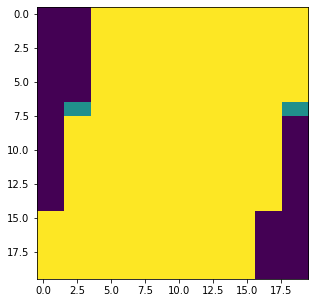

In [6]:
plt.figure(figsize=(5,5))
plt.imshow(data_matrix[800,1:].reshape(20,20))  
plt.show()

+ Creation of the dependent variable: Y matrix 

+ Variable to be predicted 
+ (onehot)

In [7]:
df.head()

,m_label,r0c0,r0c1,r0c2,r0c3,r0c4,r0c5,r0c6,r0c7,r0c8,...,r19c10,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19
0,64258,1,1,1,21,101,210,255,255,255,...,1,1,1,1,1,1,163,255,255,255
1,64257,1,1,1,21,101,210,255,255,255,...,1,1,1,1,1,1,163,255,255,255
2,61442,1,1,1,21,101,210,255,255,255,...,1,1,1,1,1,1,163,255,255,255
3,61441,1,1,1,21,101,210,255,255,255,...,1,1,1,1,1,1,163,255,255,255
4,9674,1,1,1,1,1,1,1,1,132,...,255,132,1,1,1,1,1,1,1,1


In [8]:
Y=np.zeros((data_matrix.shape[0],10))   
print ('Y dimension: {}'.format(Y.shape))  
print ('')
for i in range(10):
    Y[:,i]=np.where(data_matrix[:,0]==i,1,0)
print(Y[0:10,:]) # first 10 rows

Y dimension: (832670, 10)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


+ Separate tag columns and remove columns that contain 0

In [9]:
tags=data_matrix[:,0]        
X=data_matrix[:,1:]              
print ('Original dimension of X: {}'.format(X.shape)) 
print ('')
X=X[:,X.sum(axis=0)!=0]            
print ('Clean dimension of X: {}'.format(X.shape))

Original dimension of X: (832670, 400)

Clean dimension of X: (832670, 400)


+ Divide data between train and test

In [10]:
X_train, Y_train=X[0:30000,:], Y[0:30000,:]        
X_train_sk=X_train.copy()                         

X_test, Y_test=X[30000:,:], Y[30000:,:]            
X_test_sk=X_test.copy()                            

print ('Train dimensions: X={}, Y={}'.format(X_train.shape, Y_train.shape))  
print ('')
print ('Test dimensions: X={}, Y={}'.format(X_test.shape, Y_test.shape))

Train dimensions: X=(30000, 400), Y=(30000, 10)

Test dimensions: X=(802670, 400), Y=(802670, 10)


+ Train & Test tags

In [11]:
train_tags=tags[0:30000]       
test_tags=tags[30000:]        

print ('Train tags dimensions: {}'.format(train_tags.shape))
print ('')
print ('Test tags dimensions: {}'.format(test_tags.shape))

Train tags dimensions: (30000,)

Test tags dimensions: (802670,)


+ Optimal parameters search for  10 models

In [12]:
initial_val=np.random.rand(X_train.shape[1]) 

A_opt=np.zeros((X_train.shape[1],10))        

+ Regularization L2.

In [13]:
#gridsearching obtained value
lambda_reg=100.

+ Optimization

In [14]:
def coste(X,a,y,lambda_reg):              # funcion coste, funcion a minimizar 
    return -(np.sum(np.log(f(X,a)))+np.dot((y-1).T,(np.dot(X,a))))/y.size + lambda_reg/(2.0*y.size)*np.dot(a[1:],a[1:])

In [15]:
def f(X,a):                                 # funcion logistica, sigmoide, funcion del modelo, con z=X*alfa, el producto escalar
    return 1.0/(1.0+np.exp(-np.dot(X,a)))   # Boltzmann con pivote, alfa[i]=0

In [16]:
def grad_coste(X,a,y,lambda_reg):          # gradiente de la funcion coste con regularizacion
    return (np.dot(X.T,(f(X,a)-y)))/y.size + lambda_reg/(2.0*y.size)*np.concatenate(([0], a[1:])).T

In [17]:
inicio_opt=time.time()                       # inicio optimizacion
for i in range(10):
    print ('\n\nOptimizando {} frente al resto.'.format(i))

    def opt_coste(a):                        # funcion a minimizar
        return coste(X_train, a, Y_train[:,i], lambda_reg) 

    def opt_grad_coste(a):                   # gradiente 
        return grad_coste(X_train, a, Y_train[:,i], lambda_reg)	

    # metodo Nelder-Mead, Powell, CG, BFGS, Newton-CG, L-BFGS-B, TNC, COBYLA, SLSQP, trust-constr, 
    # dogleg, trust-ncg, trust-exact, trust-krylov (tambien custom)            
    metodo='trust-constr'
    print ('Optimizacion {}...'.format(metodo)) # minimizacion, optimizacion
    i_opt=time.time() 
    modelo=minimize(opt_coste, initial_val, method=metodo, jac=opt_grad_coste, tol=1e-4, options={'disp':True}) 
    print ('Hecho.')
    print ("Tiempo optimizacion: {:.2f} segundos." .format(time.time()-i_opt))  
    A_opt[:,i]=modelo.x

t_custom=time.time()-inicio_opt   # tiempo desde inicio hasta final minimizacion
print ('\nTiempo total optimizacion custom: {:.2f} segundos.\n' .format(t_custom))



Optimizando 0 frente al resto.
Optimizacion trust-constr...
`xtol` termination condition is satisfied.
Number of iterations: 29, function evaluations: 29, CG iterations: 28, optimality: 1.71e+02, constraint violation: 0.00e+00, execution time: 2.5e+01 s.
Hecho.
Tiempo optimizacion: 26.01 segundos.


Optimizando 1 frente al resto.
Optimizacion trust-constr...
`xtol` termination condition is satisfied.
Number of iterations: 29, function evaluations: 29, CG iterations: 28, optimality: 1.71e+02, constraint violation: 0.00e+00, execution time: 2.4e+01 s.
Hecho.
Tiempo optimizacion: 25.13 segundos.


Optimizando 2 frente al resto.
Optimizacion trust-constr...
`xtol` termination condition is satisfied.
Number of iterations: 29, function evaluations: 29, CG iterations: 28, optimality: 1.71e+02, constraint violation: 0.00e+00, execution time: 2.8e+01 s.
Hecho.
Tiempo optimizacion: 29.29 segundos.


Optimizando 3 frente al resto.
Optimizacion trust-constr...
`xtol` termination condition is sat

+ Model check

In [18]:
y_pred=[]                  # etiquetas predichas
y_prob=[]                  # probabilidades de las etiquetas predichas

def resumen(datos):        # testeo
    for e in datos:
        nombre, etiqueta, Xs=e         
        etiq=etiqueta.size
        probs=np.zeros((etiq,2))      # etiquetas con su probabilidad
        cuenta=0                      # conteo de aciertos
        for muestra in range(etiq): 
            for n in range(10):
                alfa=A_opt[:,n]       # parametros de softmax
                probs[n,0]=n
                probs[n,1]=f(Xs[muestra,:],alfa)      # evaluacion de la prediccion
                
            probs=probs[probs[:,1].argsort()[::-1]]   # se pone la prob mas alta al principio
            y_pred.append(probs[0,0])
            y_prob.append(probs[0,1])
            if probs[0,0]==etiqueta[muestra]:         # si se acierta +1
                cuenta+=1
        print ("\n{}".format(nombre))
        print ("{} correctos de {} ==> {:.4}% correcto".format(cuenta, etiq, cuenta/etiq*100))

+ Outcome train & test Custom.

In [19]:
resumen([('Training  :', train_tags, X_train)])
resumen([('Test  :', test_tags, X_test)])


Training  :
0 correctos de 30000 ==> 0.0% correcto


KeyboardInterrupt: 

+ Save training alphas to csv

In [ ]:
print (' Parameter matrix dimensions={}'.format(A_opt.shape))
df2=pd.df(A_opt, columns=[i+1 for i in range(A_opt.shape[1])])  
df2.to_csv('alphas.csv', index=False)

### SKLEARN VERSION

In [2]:
from sklearn.linear_model import LogisticRegression

In [3]:
ini_opt_sk=time.time()
logreg=LogisticRegression(C=0.01, penalty='l2', tol=0.0001, max_iter=70,
                          solver='lbfgs', multi_class='multinomial').fit(X_train_sk, train_tags)
t_sklearn=time.time()-ini_opt_sk
print ('\nTiempo total optimizacion sklearn: {:.2f} segundos.\n' .format(t_sklearn))

NameError: name 'time' is not defined

+ Sklearn check

In [ ]:
def resumen_sk(datos):
    for e in datos:
        nombre, etiqueta, Xs=e
        etiq=etiqueta.size
        
        y_pred_sk=logreg.predict(Xs)
        
        cuenta=0
        for muestra in range(etiq):
            if y_pred_sk[muestra]==etiqueta[muestra]:         
                cuenta+=1
        
        print ("\n{}".format(nombre))
        print ("{} correctos de {} ==> {:.4}% correcto".format(cuenta, etiq, cuenta/etiq*100))

+ Train & test custom outcome

In [ ]:
resumen_sk([('Entranamiento  :', etiquetas_train, X_train_sk)])
resumen_sk([('Test  :', etiquetas_test, X_test_sk)])

+ Time comparison

In [ ]:
print ('SkLearn es {:.2f} veces más rapido.'.format(t_custom/t_sklearn))

+ Absolut difference between both models

In [ ]:
y_pred_sk=logreg.predict(X_test_sk)
comp=[y_pred[30000:][i]==y_pred_sk[i] for i in range(len(y_pred[30000:]))]
n_equal=len([e for e in comp if e==False])/len(y_pred_sk)

print ('Difference of {:.2f}%.between both models'.format(n_equal*100))

+ Hit between train & test in both models

In [ ]:
resumen([('Entranamiento Custom:', etiquetas_train, X_train)])
resumen([('Test Custom:', etiquetas_test, X_test)])
print ('')
resumen_sk([('Entranamiento SkLearn:', etiquetas_train, X_train_sk)])
resumen_sk([('Test SkLearn:', etiquetas_test, X_test_sk)])